<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW3_Classification_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Кака всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [ ]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [24]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = []

    def sigmoid(self, z):
            return 1 / (1 + np.exp(-z))

    def calc_loss(self, X, y):
        m = X.shape[0]
        predictions = self.sigmoid(np.dot(X, self.w))
        epsilon = 1e-5
        loss = - (1 / m) * np.sum(y * np.log(predictions + epsilon) +
                                    (1 - y) * np.log(1 - predictions + epsilon))
        return loss

    def calc_gradient(self, X, y):
        m = X.shape[0]
        predictions = self.sigmoid(np.dot(X, self.w))
        gradient = (1 / m) * np.dot(X.T, (predictions - y))
        return gradient

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features) if self.w0 is None else self.w0
        prev_w = np.copy(self.w)

        for i in range(self.max_iter):
            if self.gd_type == 'full':
                gradient = self.calc_gradient(X, y)
            elif self.gd_type == 'stochastic':
                idx = np.random.randint(0, n_samples)
                gradient = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])
            else:
                raise ValueError("gd_type must be 'full' or 'stochastic'")

            self.w -= self.eta * gradient
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            if np.linalg.norm(self.w - prev_w) < self.tolerance:
                break
            prev_w = np.copy(self.w)

        return self

    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Model is not trained yet.')
        return self.sigmoid(np.dot(X, self.w))

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

Теперь проверим работу вашего класса на синтетических данных.

In [32]:
%pylab inline
import pandas as pd
from sklearn.metrics import accuracy_score,roc_auc_score, precision_recall_curve, roc_curve, auc

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

Populating the interactive namespace from numpy and matplotlib


In [26]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=12345)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12345)

In [27]:
model = LogReg(gd_type='full', eta=0.1, max_iter=1000, tolerance=1e-4)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Acc:', accuracy)
print('Loss hist [:10]:', model.loss_history[:10])

Acc: 0.7671666666666667
Loss hist [:10]: [0.5727345711440743, 0.5549128559681845, 0.5441181320483135, 0.5361076550500806, 0.5297977662200223, 0.5246987145908221, 0.5205099123727542, 0.5170219924329547, 0.5140818507638554, 0.5115750377187835]


**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

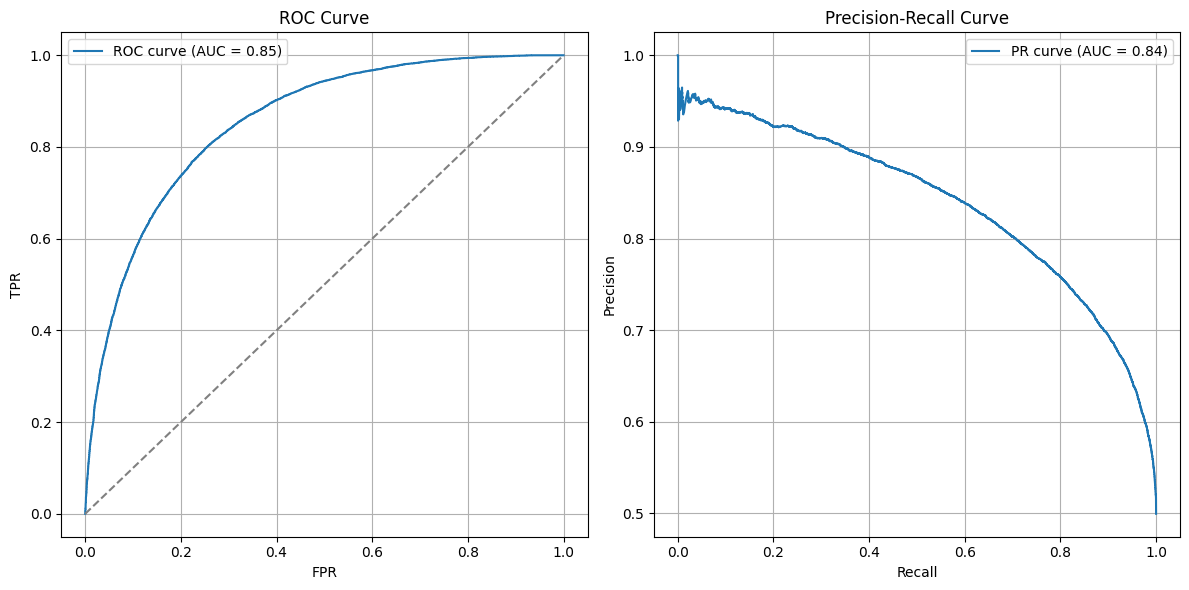

ROC-AUC: 0.8538
PR-AUC: 0.8395


In [28]:
model = LogReg(gd_type='full', eta=0.1, max_iter=1000, tolerance=1e-4)
model.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')


# **Часть 2. Отбор признаков (5 баллов)**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from time import time

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные** \

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [3]:
!pwd

/content


In [34]:
PATH_TO_DATASET = 'train.csv'

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
data.dropna(inplace=True) # Скачал DS по ссылке из TG канала с ДЗ, т.к. kaggle запрашивал ver. Здесь было 37 NaN значений

target = data.target.values

data = data.drop('target', axis=1)

In [35]:
categorical_columns = [col for col in data.columns if col.endswith('cat')]
bin_columns = [col for col in data.columns if col.endswith('bin')]
num_columns = data.columns.drop(categorical_columns+bin_columns)

### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [36]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded = encoder.fit_transform(data[categorical_columns])

data = data.drop(categorical_columns, axis=1)
cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(categorical_columns), index=data.index)
data = pd.concat([data, cat_encoded_df], axis=1)

data.shape[1]

227

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.


In [40]:
svm_limit = 20000
X_train_svm = X_train[:svm_limit]
y_train_svm = y_train[:svm_limit]

In [41]:
models = {
    'LogReg': LogisticRegression(random_state=12345),
    'KNN': KNeighborsClassifier()
}

for model_name, model in models.items():
    start_time = time()
    model.fit(X_train, y_train)
    end_time = time()

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(model_name)
    print(f'Время обучения: {(end_time - start_time):.2f} сек.')
    print(f'ROC-AUC: {roc_auc:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogReg
Время обучения: 10.44 сек.
ROC-AUC: 0.6206
KNN
Время обучения: 0.41 сек.
ROC-AUC: 0.5148


In [42]:
svm_model = SVC(probability=True, random_state=124)
start_time = time()
svm_model.fit(X_train_svm, y_train_svm)
end_time = time()
y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
print(f'SVM (на 20000 данных в группе разрешили):')
print(f'Время обучения: {(end_time - start_time):.2f} сек.')
print(f'ROC-AUC: {roc_auc_svm:.4f}')

SVM (на 20000 данных в группе разрешили):
Время обучения: 237.44 сек.
ROC-AUC: 0.5404


In [43]:
param_grids = {
    'LogReg': {
        'C': [0.1, 1, 10]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7]
    }
}

for model_name, model in models.items():
    print(f'Оптимизация для {model_name}:')
    grid = GridSearchCV(model, param_grids[model_name], scoring='roc_auc', cv=3, n_jobs=-1)

    start_time = time()
    grid.fit(X_train, y_train)
    end_time = time()

    best_model = grid.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f'Лучшие параметры: {grid.best_params_}')
    print(f'Время обучения: {(end_time - start_time):.2f} сек')
    print(f'ROC-AUC: {roc_auc:.4f}')

Оптимизация для LogReg:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Лучшие параметры: {'C': 0.1}
Время обучения: 70.60 сек
ROC-AUC: 0.6198
Оптимизация для KNN:
Лучшие параметры: {'n_neighbors': 7}
Время обучения: 1518.92 сек
ROC-AUC: 0.5183


In [44]:
svm_params = {
    'C': [0.1, 1, 10]
}

svm_model = SVC(probability=True, random_state=12345)
grid_svm = GridSearchCV(svm_model, svm_params, scoring='roc_auc', cv=2, n_jobs=-1)

start_time = time()
grid_svm.fit(X_train_svm, y_train_svm)
duration = time() - start_time

best_svm = grid_svm.best_estimator_
y_pred_proba_svm = best_svm.predict_proba(X_test)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

print(f'SVM (на 20000 данных, после подбора параметров):'')
print(f'Лучшие параметры: {grid_svm.best_params_}')
print(f'Время обучения: {duration:.2f} сек')
print(f'ROC-AUC: {roc_auc_svm:.4f}')

SVM (на 20000 данных, после подбора параметров):
Лучшие параметры: {'C': 10}
Время обучения: 525.93 секунд
ROC-AUC: 0.5425



### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроеным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)

- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)




In [45]:
lr = LogisticRegression(random_state=12345).fit(X_train, y_train)
start_time = time()
lr.fit(X_train, y_train)

feature_importances = abs(lr.coef_[0])
top_150_indices = np.argsort(feature_importances)[-150:]
X_train_top150 = X_train.iloc[:, top_150_indices]
X_test_top150 = X_test.iloc[:, top_150_indices]
end_time = time()

print(f'Итоговое кол-во признаков: {X_train_top150.shape[1]}')
print(f'Время, затраченное на FSLR: {(end_time - start_time):.2f} сек.')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Итоговое кол-во признаков: 150
Время, затраченное на FSLR: 10.78 сек.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
lr_top150 = LogisticRegression(random_state=12345).fit(X_train_top150, y_train)

y_pred_proba_top150 = lr_top150.predict_proba(X_test_top150)[:, 1]
roc_auc_top150 = roc_auc_score(y_test, y_pred_proba_top150)

print(f'ROC-AUC на топ-150 признаках: {roc_auc_top150:.4f}')

ROC-AUC на топ-150 признаках: 0.6163


### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другия свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

l1_log_reg = LogisticRegression(penalty='l1', solver='liblinear', random_state=12345)
grid_search = GridSearchCV(estimator=l1_log_reg, param_grid=param_grid, cv=3, scoring='roc_auc').fit(X_train, y_train)

best_C = grid_search.best_params_['C']
print(f'Оптимальное значение C: {best_C}')

Оптимальное значение C: 0.1


In [49]:
final_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, random_state=12345).fit(X_train, y_train)
print(f'Число ненулевых весов: {np.sum(final_model.coef_[0] != 0)}')
print(f'Число ненулевых весов, окр. до 2 знаков: {np.sum(np.round(final_model.coef_[0], 2) != 0)}')

Число ненулевых весов: 95
Число ненулевых весов, окр. до 2 знаков: 86


Да, удалось отобрать 150 признаков за 1 шаг

### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

-  Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

In [52]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

def calculate_t_statistic(X, y):
    t_statistics = {}
    for feature in X.columns:
        group_1 = X[y == 1][feature]
        group_0 = X[y == 0][feature]

        t_stat, p_value = stats.ttest_ind(group_1, group_0, equal_var=False)
        t_statistics[feature] = abs(t_stat)

    return t_statistics

start_time = time()

scaler = StandardScaler()
scaled_continuous_features = scaler.fit_transform(X_train[num_columns])
scaled_continuous_features_train = pd.DataFrame(scaled_continuous_features, columns=X_train[num_columns].columns)

t_statistics = calculate_t_statistic(scaled_continuous_features_train, y_train)
sorted_t_stats = sorted(t_statistics.items(), key=lambda x: x[1], reverse=True)

num_top_features = len(sorted_t_stats) // 2
top_features = [feature for feature, _ in sorted_t_stats[:num_top_features]]

X_train_selected = pd.concat([X_train[top_features], X_train.drop(num_columns, axis=1)], axis=1)
end_time = time()

model = LogisticRegression(solver='liblinear').fit(X_train_selected, y_train)

y_pred = model.predict(X_test[X_train_selected.columns])
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {roc_auc}')

end_time = time()
print(f'Время отбора признаков: {end_time - start_time} секунд')

ROC-AUC: 0.5002869489688669
Время отбора признаков: 9.163189172744751 секунд


### **Методы-обёртки**

### **Задание 8 (бонус, 1 балл)**


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди каждый из признаков и смотрим, как это влияет на качество модели, обученной без удаленного признака. Удаляем признаки таким жадным способом.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур много. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 150 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

Встроенный метод:
- преимущества. Интерпретируемость, сразу смотрят на связку признаков, дают более релевантные признаки
- Недостатки. Зависимость от выбранной модели (к примеру, нужно масштабирвоать данные в LR), а также время при большом объёме данных


Метод фильтрации:
- преимущества. Просты, быстры, доказаны. Хорошо работают, если огромные объёмы данных, а времени на обучение модели нет
- Недостатки. Не учитывают зависимости признаков между собой.


Встроенные методы показали себя лучше, чем стат.

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
PATH = 'train (1).csv'
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [3]:
data.isna().sum().sum()

2594

In [4]:
data.fillna('', inplace=True)

In [5]:
data.isna().sum().sum()

0

- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [6]:
for col in data.select_dtypes(include=['int64', 'float64']).columns:
    print(f'{col}: {data[col].nunique()}')

id: 7613
target: 2


У нас по сути 1 числовой столбец, который не несёт никакой информации - удалим из выборки

- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

In [7]:
data['target'].value_counts(normalize=True)

,proportion
target,
0,0.57034
1,0.42966


In [8]:
data['target'].value_counts()

,count
target,
0,4342
1,3271


Соотношение классов необходимо учитывать для корректного обучения модели: чтобы предотвратить ситуацию, когда модель будет смотреть на мажорный класс, чтобы её меньше штрафовали. А также для выбора будущих метрик.

- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [9]:
data['merged_text'] = data['keyword'] + ' ' + data['location'] + ' ' + data['text']

In [10]:
data

,id,keyword,location,text,target,merged_text
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake...
1,4,,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' ar...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation ..."
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska a...
...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse i...
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control...
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. h...
7611,10872,,,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collide...


- Наконец, поделите данные на тренировочную и тестовую выборки.

In [11]:
X = data['merged_text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [12]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

X_train_vectorized.shape

(6090, 20186)

- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [13]:
lr_model = LogisticRegression(random_state=12345)
lr_model.fit(X_train_vectorized, y_train)

y_pred_lr = lr_model.predict(X_test_vectorized)
f1_lr = f1_score(y_test, y_pred_lr)

print('F1:', f1_lr)

F1: 0.7580128205128205


- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [14]:
svc_model = SVC(random_state=12345)
svc_model.fit(X_train_vectorized, y_train)

y_pred_svc = svc_model.predict(X_test_vectorized)

f1_svc = f1_score(y_test, y_pred_svc)
print('F1:', f1_svc)

F1: 0.7584459459459459


### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

In [15]:
vectorizer = CountVectorizer(min_df=0.02, max_df=0.8, max_features=1000, ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print(f'Кол-во признаков после настройки CountVectorizer: {X_train_vectorized.shape[1]}')
print(f'Кол-во объектов: {X_train_vectorized.shape[0]}')

Кол-во признаков после настройки CountVectorizer: 80
Кол-во объектов: 6090


1. min_df = 0.02: Игнор словБ которые попадаются меньше, чем в n% доках. Убирает шум
2. max_df=0.8: Исключает частые слова, которые встречаются более чем в n% доках.
3. max_features = 1000: max(len(dict))
4. ngram_range=(1, 2): Захватывает больше смысла: учёт униграм и биграм

In [16]:
lr_model = LogisticRegression(random_state=12345)
lr_model.fit(X_train_vectorized, y_train)
y_pred_lr = lr_model.predict(X_test_vectorized)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"F1 (Логистическая регрессия после настройки CountVectorizer): {f1_lr}")


F1 (Логистическая регрессия после настройки CountVectorizer): 0.6112510495382032


In [17]:
svc_model = SVC(random_state=12345)
svc_model.fit(X_train_vectorized, y_train)

y_pred_svc = svc_model.predict(X_test_vectorized)
f1_svc = f1_score(y_test, y_pred_svc)

print(f'F1 (SVC после настройки CountVectorizer): {f1_svc}')

F1 (SVC после настройки CountVectorizer): 0.599640933572711


### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [18]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10]
}

lr = LogisticRegression(random_state=12345)
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=3, scoring='f1', n_jobs=-1)

grid_search_lr.fit(X_train_vectorized, y_train)

best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

print(f'Лучшие параметры (Лог. рег.): {best_params_lr}')
print(f'Лучший F1 (Лог. рег.): {best_score_lr}')


Лучшие параметры (Лог. рег.): {'C': 10}
Лучший F1 (Лог. рег.): 0.591976255369606


- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [19]:
param_grid_svc = {
    'C': [0.1, 1, 10, 100]
}

svc = SVC(random_state=12345)
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=3, scoring='f1', n_jobs=-1)

grid_search_svc.fit(X_train_vectorized, y_train)

best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_

print(f'Лучшие параметры (SVC): {best_params_svc}')
print(f'Лучший F1 (SVC): {best_score_svc}')

Лучшие параметры (SVC): {'C': 10}
Лучший F1 (SVC): 0.595586030838318


Метрика практически не увеличилась. Подбор гиперпараметров был скуден ввиду малых вычислительных мощностей. C - сила регуляризации для LR и сила штрафа в SVM.

### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [20]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.fillna('')
        combined_text = X['keyword'] + ' ' + X['location'] + ' ' + X['text']
        return combined_text


df = pd.read_csv(PATH)

X = df[['keyword', 'location', 'text']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

pipeline_lr = Pipeline([
    ('preprocessing', Preprocessor()),
    ('vectorizer', CountVectorizer()),
    ('regression', LogisticRegression())
])

pipeline_svc = Pipeline([
    ('preprocessing', Preprocessor()),
    ('vectorizer', CountVectorizer()),
    ('svc', SVC())
])

pipeline_lr.fit(X_train, y_train)
pipeline_svc.fit(X_train, y_train)

lr_accuracy = pipeline_lr.score(X_test, y_test)
svc_accuracy = pipeline_svc.score(X_test, y_test)

print(f'Точность модели LR: {lr_accuracy * 100:.2f}%')
print(f'Точность модели SVC: {svc_accuracy * 100:.2f}%')

Точность модели LR: 80.17%
Точность модели SVC: 81.22%


### **Выводы**

Зафиксируйте выводы работы. Проанализируйте, что проделано и какие результаты вы получили. Заполняется в свободной форме.

В среднем метод SVM работает лучше. Была проделана предобработка данных в виде concat трёх текстовых столбцов, NaN значения были заполнены пустыми строками. Далее текста токенизировались CountVectorizer'ом, который на данной задаче показал неплохие результаты в F1 мере.

## Чей кот?

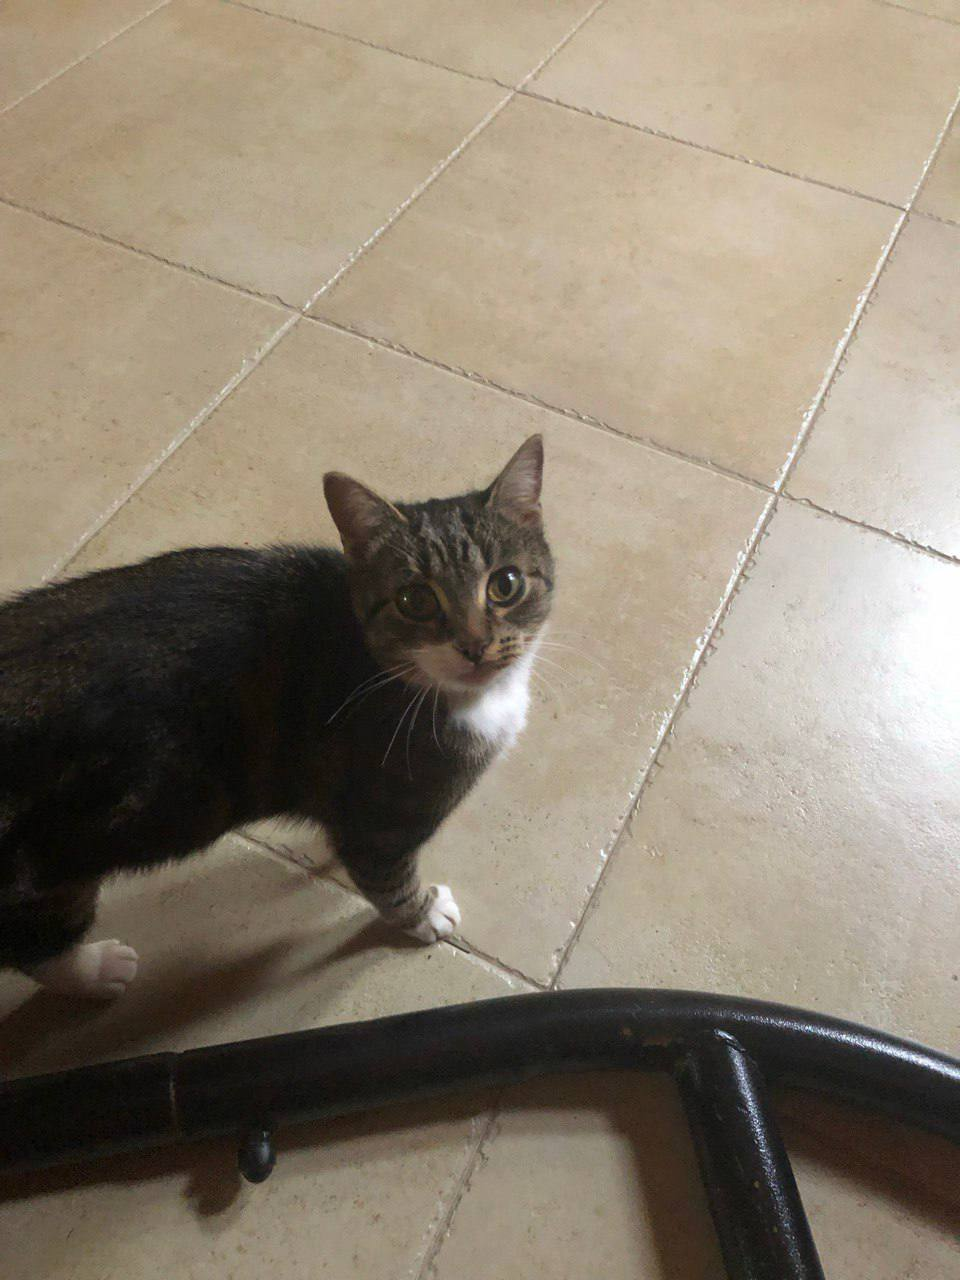